In [25]:
import geopandas as gpd
import pandas as pd
from pathlib import Path
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

In [2]:
gdf = gpd.read_file("/mnt/store-lidarhd/projet-LHD/IA/BDForet/Data/PureForestID/metadata/PureForestID-patches.gpkg")
gdf = gdf[gdf.split.isin(["test","val"])]
gdf = gdf[["split", "patch_num", "bdforet_identifier","bdforet_cat_code", "bdforet_cat_name","inventory_species_label", ]]
print(gdf.columns)
gdf.head()

Index(['split', 'patch_num', 'bdforet_identifier', 'bdforet_cat_code',
       'bdforet_cat_name', 'inventory_species_label'],
      dtype='object')


,split,patch_num,bdforet_identifier,bdforet_cat_code,bdforet_cat_name,inventory_species_label
0,val,00035_00000,FORESTIE0000000000100093,FF1-14-14,Forêt fermée de robinier pur,14
1,val,00035_00001,FORESTIE0000000000100093,FF1-14-14,Forêt fermée de robinier pur,14
2,val,00035_00002,FORESTIE0000000000100093,FF1-14-14,Forêt fermée de robinier pur,14
3,val,00035_00003,FORESTIE0000000000100093,FF1-14-14,Forêt fermée de robinier pur,14
4,val,00035_00004,FORESTIE0000000000100093,FF1-14-14,Forêt fermée de robinier pur,14


In [3]:
PREDICTIONS_FOLDER_VAL = Path("/mnt/store-lidarhd/projet-LHD/IA/MYRIA3D-SHARED-WORKSPACE/CGaydon/runs/2023-11-03/17-47-28")
PREDICTIONS_FOLDER_TEST = Path("/mnt/store-lidarhd/projet-LHD/IA/MYRIA3D-SHARED-WORKSPACE/CGaydon/runs/2023-11-03/17-46-48/")
df_val = pd.read_csv(PREDICTIONS_FOLDER_VAL / "predictions.csv")
df_test = pd.read_csv(PREDICTIONS_FOLDER_TEST / "predictions.csv")
df = pd.concat([df_val, df_test])
df = df.drop_duplicates("patch_id",keep="first")

mapping = {0: "FF1-09-09_Hêtre",
  1: "FF1-10-10_Châtaignier",
  2: "FF1-14-14_Robinier",
  3: "FF1G01-01_Chêne_décidus",
  4: "FF1G06-06_Chêne_sempervirent",
  5: "FF2-51-51_Pin_maritime",
  6: "FF2-52-52_Pin_sylvestre",
  7: "FF2-57-57_Pin_alep",
  8: "FF2-63-63-Mélèze",
  9: "FF2-64-64_Douglas",
  10: "FF2G53-53_Pin_laricio_Pin_noir",
  11: "FF2G61-61_Sapin-Epicéa"}
df["targets"] = df["targets"].apply(lambda t: mapping[t])
df["preds"] = df["preds"].apply(lambda t: mapping[t])
df.head()

,patch_id,preds,targets
0,00194_00000,FF1-10-10_Châtaignier,FF2G61-61_Sapin-Epicéa
3,00266_00000,FF2G61-61_Sapin-Epicéa,FF2G61-61_Sapin-Epicéa
6,00266_00001,FF2G61-61_Sapin-Epicéa,FF2G61-61_Sapin-Epicéa
9,00266_00002,FF2G61-61_Sapin-Epicéa,FF2G61-61_Sapin-Epicéa
12,00266_00003,FF2G61-61_Sapin-Epicéa,FF2G61-61_Sapin-Epicéa


In [4]:
merge = gdf.merge(df, left_on="patch_num", right_on="patch_id", how="inner")
# merge["OK"] = (merge["preds"] == merge["targets"]).astype(int)
# merge["NOK"] = (merge["preds"] != merge["targets"]).astype(int)
print(len(merge))
merge.head()

41891


,split,patch_num,bdforet_identifier,bdforet_cat_code,bdforet_cat_name,inventory_species_label,patch_id,preds,targets
0,val,00035_00000,FORESTIE0000000000100093,FF1-14-14,Forêt fermée de robinier pur,14,00035_00000,FF1-14-14_Robinier,FF1-14-14_Robinier
1,val,00035_00001,FORESTIE0000000000100093,FF1-14-14,Forêt fermée de robinier pur,14,00035_00001,FF1-14-14_Robinier,FF1-14-14_Robinier
2,val,00035_00002,FORESTIE0000000000100093,FF1-14-14,Forêt fermée de robinier pur,14,00035_00002,FF1-14-14_Robinier,FF1-14-14_Robinier
3,val,00035_00003,FORESTIE0000000000100093,FF1-14-14,Forêt fermée de robinier pur,14,00035_00003,FF1-14-14_Robinier,FF1-14-14_Robinier
4,val,00035_00004,FORESTIE0000000000100093,FF1-14-14,Forêt fermée de robinier pur,14,00035_00004,FF1-14-14_Robinier,FF1-14-14_Robinier


In [5]:
groups = merge.groupby(["bdforet_identifier","bdforet_cat_code","targets","preds"]).size().reset_index()
pivot = groups.pivot(index=["bdforet_identifier","targets"],columns="preds",values=0).fillna(0).astype(int)
pivot["consensus"] = pivot.idxmax(axis=1)
pivot = pivot.reset_index()
pivot["accurate"] = pivot["consensus"] == pivot["targets"]
pivot.to_csv(PREDICTIONS_FOLDER_VAL/"predictions-pivot-by-polygon.csv")
pivot

preds,bdforet_identifier,targets,FF1-09-09_Hêtre,FF1-10-10_Châtaignier,FF1-14-14_Robinier,FF1G01-01_Chêne_décidus,FF1G06-06_Chêne_sempervirent,FF2-52-52_Pin_sylvestre,FF2-57-57_Pin_alep,FF2-63-63-Mélèze,FF2-64-64_Douglas,FF2G53-53_Pin_laricio_Pin_noir,FF2G61-61_Sapin-Epicéa,consensus,accurate
0,FORESTIE0000000000100093,FF1-14-14_Robinier,0,0,12,0,0,0,0,0,0,0,0,FF1-14-14_Robinier,True
1,FORESTIE0000000000100104,FF1-14-14_Robinier,0,0,36,0,0,0,0,0,0,0,0,FF1-14-14_Robinier,True
2,FORESTIE0000000000100240,FF1-14-14_Robinier,0,0,9,0,0,0,0,0,0,0,0,FF1-14-14_Robinier,True
3,FORESTIE0000000000401455,FF1G01-01_Chêne_décidus,0,0,49,83,27,6,0,0,0,0,0,FF1G01-01_Chêne_décidus,True
4,FORESTIE0000000000402323,FF1G01-01_Chêne_décidus,145,40,0,628,0,2,0,0,0,0,0,FF1G01-01_Chêne_décidus,True
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
88,FORESTIE0000000008208414,FF1-14-14_Robinier,0,0,6,0,0,0,0,0,0,0,0,FF1-14-14_Robinier,True
89,FORESTIE0000000008208450,FF1-14-14_Robinier,0,0,4,0,0,0,0,0,0,0,0,FF1-14-14_Robinier,True
90,FORESTIE0000000008208460,FF1-14-14_Robinier,0,0,6,0,0,0,0,0,0,0,0,FF1-14-14_Robinier,True
91,FORESTIE0000000008210212,FF1G01-01_Chêne_décidus,2,0,3376,1537,0,5,0,1,1,3,0,FF1-14-14_Robinier,False


In [6]:
synthesis = pivot.groupby("targets").agg({"accurate":"mean","bdforet_identifier":"size"}).round(2)
synthesis = synthesis.rename(columns={"accurate":"accuracy","bdforet_identifier":"num_bdforet_polygons"})
synthesis.to_csv(PREDICTIONS_FOLDER_VAL/"predictions-accuracy-by-class.csv")
synthesis


preds,accuracy,num_bdforet_polygons
targets,,
FF1-09-09_Hêtre,0.67,6
FF1-10-10_Châtaignier,0.40,5
FF1-14-14_Robinier,0.92,24
FF1G01-01_Chêne_décidus,0.64,14
FF1G06-06_Chêne_sempervirent,0.83,6
FF2-52-52_Pin_sylvestre,0.88,8
FF2-57-57_Pin_alep,0.75,4
FF2-63-63-Mélèze,1.00,2
FF2-64-64_Douglas,0.70,10


In [7]:
synthesis.sort_values("accuracy",ascending=False)

preds,accuracy,num_bdforet_polygons
targets,,
FF2-63-63-Mélèze,1.00,2
FF2G61-61_Sapin-Epicéa,1.00,8
FF1-14-14_Robinier,0.92,24
FF2-52-52_Pin_sylvestre,0.88,8
FF1G06-06_Chêne_sempervirent,0.83,6
FF2G53-53_Pin_laricio_Pin_noir,0.83,6
FF2-57-57_Pin_alep,0.75,4
FF2-64-64_Douglas,0.70,10
FF1-09-09_Hêtre,0.67,6


In [8]:
# accuracy at the polygon level
OK = len(pivot[pivot.accurate])
NOK = len(pivot[~pivot.accurate])
OK/(OK+NOK)

0.7956989247311828

In [9]:
# erreurs
non_accurates = pivot[~pivot.accurate].sort_values("targets")
non_accurates

preds,bdforet_identifier,targets,FF1-09-09_Hêtre,FF1-10-10_Châtaignier,FF1-14-14_Robinier,FF1G01-01_Chêne_décidus,FF1G06-06_Chêne_sempervirent,FF2-52-52_Pin_sylvestre,FF2-57-57_Pin_alep,FF2-63-63-Mélèze,FF2-64-64_Douglas,FF2G53-53_Pin_laricio_Pin_noir,FF2G61-61_Sapin-Epicéa,consensus,accurate
6,FORESTIE0000000000403437,FF1-09-09_Hêtre,0,0,10,58,0,2,0,30,0,3,0,FF1G01-01_Chêne_décidus,False
57,FORESTIE0000000004302294,FF1-09-09_Hêtre,40,0,10,49,0,1,0,0,0,0,0,FF1G01-01_Chêne_décidus,False
62,FORESTIE0000000004609242,FF1-10-10_Châtaignier,0,0,0,38,0,0,0,0,0,0,0,FF1G01-01_Chêne_décidus,False
83,FORESTIE0000000008109742,FF1-10-10_Châtaignier,3,1,65,2,0,0,0,0,0,0,0,FF1-14-14_Robinier,False
47,FORESTIE0000000003807482,FF1-10-10_Châtaignier,0,0,8,0,0,0,0,0,0,0,0,FF1-14-14_Robinier,False
33,FORESTIE0000000002436292,FF1-14-14_Robinier,0,24,0,0,0,0,0,0,5,0,25,FF2G61-61_Sapin-Epicéa,False
64,FORESTIE0000000004710749,FF1-14-14_Robinier,0,0,0,1,0,0,0,0,0,0,0,FF1G01-01_Chêne_décidus,False
34,FORESTIE0000000002446444,FF1G01-01_Chêne_décidus,0,2,0,0,0,0,0,0,1,0,0,FF1-10-10_Châtaignier,False
40,FORESTIE0000000003003939,FF1G01-01_Chêne_décidus,0,11,0,11,0,0,0,0,0,0,0,FF1-10-10_Châtaignier,False
56,FORESTIE0000000003809798,FF1G01-01_Chêne_décidus,0,0,1,0,0,0,0,0,0,0,0,FF1-14-14_Robinier,False


In [10]:
# Lien entre erreur et taille de polygone -> pas vraiment.
non_accurates["num_patches_in_polygon"] = non_accurates[pivot.columns[2:13]].sum(axis=1)
non_accurates[["targets","consensus","num_patches_in_polygon"]]

preds,targets,consensus,num_patches_in_polygon
6,FF1-09-09_Hêtre,FF1G01-01_Chêne_décidus,103
57,FF1-09-09_Hêtre,FF1G01-01_Chêne_décidus,100
62,FF1-10-10_Châtaignier,FF1G01-01_Chêne_décidus,38
83,FF1-10-10_Châtaignier,FF1-14-14_Robinier,71
47,FF1-10-10_Châtaignier,FF1-14-14_Robinier,8
33,FF1-14-14_Robinier,FF2G61-61_Sapin-Epicéa,54
64,FF1-14-14_Robinier,FF1G01-01_Chêne_décidus,1
34,FF1G01-01_Chêne_décidus,FF1-10-10_Châtaignier,3
40,FF1G01-01_Chêne_décidus,FF1-10-10_Châtaignier,22
56,FF1G01-01_Chêne_décidus,FF1-14-14_Robinier,1


In [26]:
# Confusion matrix at polygon level
reverse_mapping = {v:k for k,v in mapping.items()}
counts = pivot.groupby(["targets","consensus"]).size().reset_index().rename(columns={0:"count"})
cm = counts.pivot(index="targets",columns="consensus",values="count").fillna(0).astype(int)
cm

consensus,FF1-09-09_Hêtre,FF1-10-10_Châtaignier,FF1-14-14_Robinier,FF1G01-01_Chêne_décidus,FF1G06-06_Chêne_sempervirent,FF2-52-52_Pin_sylvestre,FF2-57-57_Pin_alep,FF2-63-63-Mélèze,FF2-64-64_Douglas,FF2G53-53_Pin_laricio_Pin_noir,FF2G61-61_Sapin-Epicéa
targets,,,,,,,,,,,
FF1-09-09_Hêtre,4,0,0,2,0,0,0,0,0,0,0
FF1-10-10_Châtaignier,0,2,2,1,0,0,0,0,0,0,0
FF1-14-14_Robinier,0,0,22,1,0,0,0,0,0,0,1
FF1G01-01_Chêne_décidus,0,2,3,9,0,0,0,0,0,0,0
FF1G06-06_Chêne_sempervirent,0,0,0,0,5,0,0,0,1,0,0
FF2-52-52_Pin_sylvestre,0,0,0,1,0,7,0,0,0,0,0
FF2-57-57_Pin_alep,0,0,0,0,0,0,3,0,1,0,0
FF2-63-63-Mélèze,0,0,0,0,0,0,0,2,0,0,0
FF2-64-64_Douglas,0,0,1,0,0,0,0,0,7,2,0


In [31]:
cm.index

array(['FF1-09-09_Hêtre', 'FF1-10-10_Châtaignier', 'FF1-14-14_Robinier',
       'FF1G01-01_Chêne_décidus', 'FF1G06-06_Chêne_sempervirent',
       'FF2-52-52_Pin_sylvestre', 'FF2-57-57_Pin_alep',
       'FF2-63-63-Mélèze', 'FF2-64-64_Douglas',
       'FF2G53-53_Pin_laricio_Pin_noir', 'FF2G61-61_Sapin-Epicéa'],
      dtype=object)

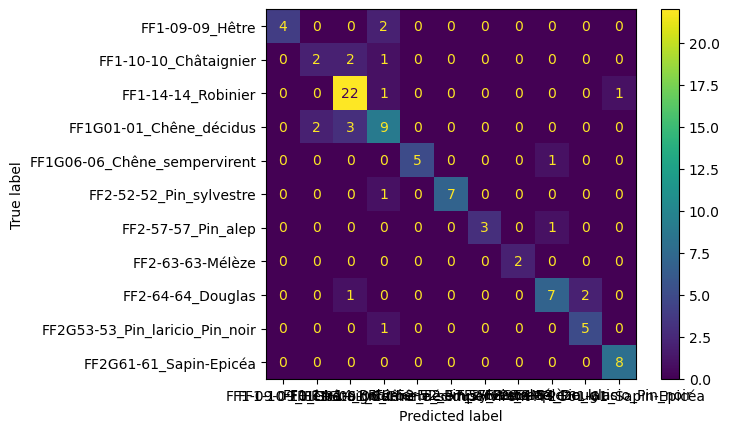

<Figure size 640x480 with 0 Axes>

In [37]:
ConfusionMatrixDisplay(cm.values, display_labels=cm.index.values).plot()
import matplotlib.pyplot as plt
plt.show() 
plt.savefig(PREDICTIONS_FOLDER_TEST / "CM-by-polygon-val-and-test.png")